In [111]:
# 第一行用来导入需要用到的模块
import json
from collections import defaultdict
from collections import Counter
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

本书将要想你介绍的是用于高效处理数据的Python工具。虽然读者各自工作的目的千差万别，但基本都需要完成以下几个大类的任务：
- 与外界进行交互<br>
    读写各种各样的文件格式和数据库
- 准备<br>
    对数据进行清理、修整、整合、规范化、重塑、切片切块、变形等处理以便进行分析。
- 转换<br>
    对数据集做一些数学和统计运算以产生新的数据集。比如说，根据分组变量对一个大表进行聚合。
- 建模和计算<br>
    键数据跟统计模型、机器学习算法或其他计算工具联系起来。
- 展示<br>
    创建交互的或静态的图片或文字摘要。
我将在本章中给出一些范例数据集，并讲解我们能对其做些什么。这些例子仅仅是为了提起你的兴趣，因此只会在一个表较高的层次进行讲解。

# 来自bit.ly的1.usa.gov数据

2011年，URL缩短服务bit.ly跟美国政府网站usa.gov合作，提供一份从生成.gov或.mil短连接的用户那里收集来的匿名数据。直到编写本书时为止，除实时数据之外，还可以下载文本文件形式的每小时快照。<br>
以每小时快照为例，文件中各行的格式为JSON（即JavaScript Object Notation，这是一种常用的Web数据格式）。例如我们只读取某个文件中的第一行，那么你所看到的结果应该是下面这样：

In [2]:
path = '../原书代码和数据/datasets/bitly_usagov/example.txt'
open(path).readline()

'{ "a": "Mozilla\\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\\/535.11 (KHTML, like Gecko) Chrome\\/17.0.963.78 Safari\\/535.11", "c": "US", "nk": 1, "tz": "America\\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\\/\\/www.facebook.com\\/l\\/7AQEFzjSi\\/1.usa.gov\\/wfLQtf", "u": "http:\\/\\/www.ncbi.nlm.nih.gov\\/pubmed\\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }\n'

Python有许多内置或第三方模块可以将JSON字符串转换成Python字典对象。这里，我将使用json模块及其loads函数逐行加载已经下载好的数据文件：

In [3]:
records = [json.loads(line) for line in open(path)]

你可能之前没用过Python，解释一下上面最后那行表达式，它叫做列表推导式（list comprehension），这是一种在一组字符串（或一组别的可迭代对象）上执行一条相同操作（json.loads）的简单方式。在一个打开的文件句柄上即可获得一个由行组成的序列。现在，records对象就成为一组Python字典了：

In [4]:
records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'c': 'US',
 'nk': 1,
 'tz': 'America/New_York',
 'gr': 'MA',
 'g': 'A6qOVH',
 'h': 'wfLQtf',
 'l': 'orofrog',
 'al': 'en-US,en;q=0.8',
 'hh': '1.usa.gov',
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991',
 't': 1331923247,
 'hc': 1331822918,
 'cy': 'Danvers',
 'll': [42.576698, -70.954903]}

注意，Python的索引是从0开始的，不想其他某些语言是从1开始的。现在，只有以字符串的形式给出想要访问的键就可以得到当前记录中相应的值：

In [5]:
records[0]['tz']

'America/New_York'

# 用处Python代码对时区进行计数

假设我们想要知道该数据集中最长出现的是哪个时区（即tz字段），得到答案的办法有很多。首先，我们用列表推导式取出一组时区：

In [6]:
time_zores = [rec['tz'] for rec in records if 'tz' in rec]
time_zores[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

只看前10个时区，我们发现有些是未知的（即空的）。虽然可以将他们过滤掉，但现在暂时先留着。接下来，为了对时区进行计数，这里结束两个办法：一个较难（只使用编制Python库），另一个较简单（使用pandas）。计数的办法之一是在遍历时区的过程中将计数值保存在字典中：

In [7]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

如果非常了解Python标准库，那么你可能会将代码写得更简洁一些：

In [8]:
def get_counts2(sequence):
    counts = defaultdict(int) # 所有的值均会被初始化为0
    for x in sequence:
        counts += 1
    return counts

我将代码写到函数里是为了获得更高的可重用性。要用它对时区进行处理，只需要将time_zones传入即可：

In [9]:
counts = get_counts(time_zores)
counts['America/New_York']

1251

In [10]:
len(time_zores)

3440

如果想要得到前10位的时区及其计数值，我们需要用到一些有关字典的处理技巧：

In [11]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

In [12]:
top_counts(counts)

[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

你可以在Python标注库中找到collections.Counter类，它能使这个任务变得更简单：

In [13]:
counts = Counter(time_zores)
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

# 用Pandas对时区进行计数

DataFrame是pandas中最重要的数据结构，它用于将数据表示为一个表格。从一组原始记录中创建DataFrame是很简单的：

In [14]:
frame = DataFrame(records)
frame.head()

,_heartbeat_,a,al,c,cy,g,gr,h,hc,hh,kw,l,ll,nk,r,t,tz,u
0,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Danvers,A6qOVH,MA,wfLQtf,1.331823e+09,1.usa.gov,NaN,orofrog,"[42.576698, -70.954903]",1.0,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,1.331923e+09,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,NaN,GoogleMaps/RochesterNY,NaN,US,Provo,mwszkS,UT,mwszkS,1.308262e+09,j.mp,NaN,bitly,"[40.218102, -111.613297]",0.0,http://www.AwareMap.com/,1.331923e+09,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,NaN,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,en-US,US,Washington,xxr3Qb,DC,xxr3Qb,1.331920e+09,1.usa.gov,NaN,bitly,"[38.9007, -77.043098]",1.0,http://t.co/03elZC4Q,1.331923e+09,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,pt-br,BR,Braz,zCaLwp,27,zUtuOu,1.331923e+09,1.usa.gov,NaN,alelex88,"[-23.549999, -46.616699]",0.0,direct,1.331923e+09,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,9b6kNl,MA,9b6kNl,1.273672e+09,bit.ly,NaN,bitly,"[42.286499, -71.714699]",0.0,http://www.shrewsbury-ma.gov/selco/,1.331923e+09,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...


In [15]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

这是frame的输出形式是摘要视图（summary view），主要用于较大的DataFrame对象。frame[tz]所返回的Series对象有一个value_counts方法，该方法可以让我们得到所需要的信息：

In [16]:
tz_counts = frame['tz'].value_counts()
tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

然后，我们想利用会图库（即matplotlib）为这段数据生成一张图片。为此，我们先给记录中未知或缺失的时区填上一个替代值。fillna函数可以替换缺失值（NA），而未知值（空字符串）则可以通过布尔型数组索引加以替换：

In [17]:
clean_tz = frame['tz'].fillna('Missing')
clean_tz[clean_tz == ''] = 'Unknown'
tz_counts = clean_tz.value_counts()
tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

利用counts对象的plot方法即可得到一张水平条形图：

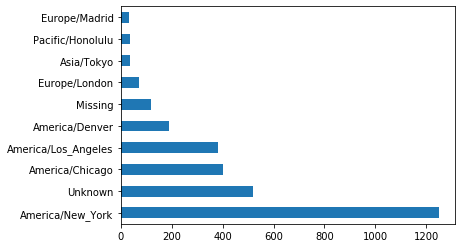

In [18]:
tz_counts[:10].plot(kind='barh', rot=0)

In [19]:
frame['a'][1]

'GoogleMaps/RochesterNY'

In [20]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [21]:
frame['a'][51]

'Mozilla/5.0 (Linux; U; Android 2.2.2; en-us; LG-P925/V10e Build/FRG83G) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1'

将这些agent字符串中的所有信息都解析处理是一件挺郁闷的工作。不过只要你掌握了Python内置的字符串函数和正则表达式，事情就好办了。比如说，我们可以将这种字符串的第一节分离出来并得到另一份用户行为摘要：

In [22]:
results = Series([x.split()[0] for x in frame.a.dropna()])
results[:5]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [23]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

现在，假设你想按Windows和非Windows用户对时区统计信息进行分解。为了简单起见，我们假定只要agent字符串中含有Windows就认为该用户为Windows用户。由于有的agent缺失，所以首先将它们从数据中移除：

In [24]:
cframe = frame[frame.a.notnull()]

其次根据a值计算出各行是否是Windows：

In [25]:
operating_system = np.where(cframe['a'].str.contains('Windows'), 'Windows', 'Not Windows')

In [26]:
operating_system[:5]

array(['Windows', 'Not Windows', 'Windows', 'Not Windows', 'Windows'],
      dtype='<U11')

接下来就可以根据时区和新得到的操作系统列表对数据进行分组了：

In [27]:
by_tz_os = cframe.groupby(['tz', operating_system])

然后通过size对分组结果进行计数（类似于上面的value_counts函数），并利用unstack对计数结果进行重塑：

In [28]:
agg_counts = by_tz_os.size().unstack().fillna(0)

In [29]:
agg_counts[:10]

,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


最后，我们来选取最常出现的时区。为了达到这个目的，我根据agg_counts中的行数构造一个间接索引数组：

In [30]:
indexer = agg_counts.sum(1).argsort()

In [31]:
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

然后我通过take按照这个顺序截取了最后10行：

In [32]:
count_subset = agg_counts.take(indexer)[-10:]

In [33]:
count_subset

,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


这里也可以生成一张条形图。我将使用stacked=True来生成一张推挤条形图

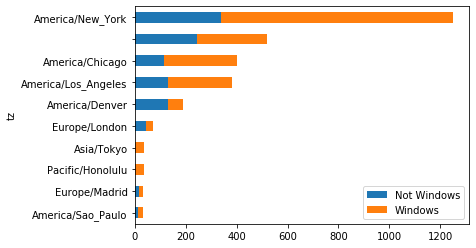

In [34]:
count_subset.plot(kind='barh', stacked=True)

由于在这张图中不太容易看清楚较小分组中Windows用户的相对比例，因此我们可以将各行规范化为‘总计为1’并重新绘图

In [35]:
normed_subset = count_subset.div(count_subset.sum(1), axis=0)

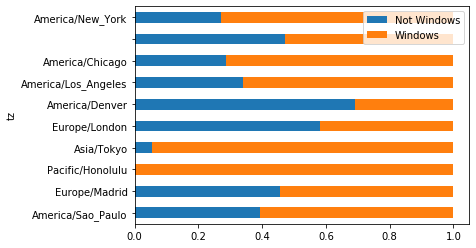

In [36]:
normed_subset.plot(kind='barh', stacked=True)

# MovieLens 1M数据集

GroupLens Research采集了一组从20世纪90年末到21世纪初由MovieLens用户提供的电影评分数据。这些数据包括电影评分、电影元数据（风格类型和年代）以及官员用户的人口统计学数据（年龄、邮编、性别和职业等）。基于机器学习算法的推荐系统一般都会对此类数据感兴趣。虽然我不会再本书中详细介绍机器学习计算，但我会告诉你如何对这种数据进行切片切块以满足实际需求。

MovieLens 1M数据集含有来自6000名用户对4000部电影的100万条评分数据。它分为三个表：评分、用户信息和电影信息。

In [37]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']

In [38]:
users = pd.read_csv('../原书代码和数据/datasets/movielens/users.dat', sep='::', header=None, names=unames)

D:\software\anaconda\install\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [39]:
rnames = ['movie_id', 'movie_id', 'rating', 'timestamp']

In [40]:
ratings = pd.read_csv('../原书代码和数据/datasets/movielens/ratings.dat', sep='::', header=None, names=rnames)

D:\software\anaconda\install\lib\site-packages\pandas\io\parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
D:\software\anaconda\install\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [41]:
mnames = ['movie_id', 'title', 'genres']

In [42]:
movies = pd.read_csv('../原书代码和数据/datasets/movielens/movies.dat', sep='::', header=None, names=mnames)

D:\software\anaconda\install\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


利用Python的切片语法，通过查看每个DataFrame的前几行即可验证数据加载工作是否一切顺利：

In [43]:
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [44]:
ratings[:5]

,movie_id,movie_id.1,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [45]:
# 排名数据中变量名有错误，这里进行修改
ratings1 = ratings.rename(columns={'movie_id':'user_id', 'movie_id.1':'movie_id'}, inplace=False)

In [46]:
ratings1[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [47]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


注意，其中的年龄和职业是以编码形式给出的，他们的具体含义请参考数据集的READE文件。分析散步在三个表中的数据可不是一件轻松的事情。假设我们想要根据性别和年龄计算某部电影的平均分，如果将所有数据都合并到一个表中的话问题就简单多了。我们现有pandas的merge函数将ratings1跟users合并到一起，然后再将movies也合并进去。pandas会根据列名的重叠情况推断出哪些列是合并键：

In [48]:
data = pd.merge(pd.merge(ratings1, users), movies)

In [49]:
data.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [50]:
data.loc[0]

user_id                                            1
movie_id                                        1193
rating                                             5
timestamp                                  978300760
gender                                             F
age                                                1
occupation                                        10
zip                                            48067
title         One Flew Over the Cuckoo's Nest (1975)
genres                                         Drama
Name: 0, dtype: object

现在，只有稍微熟悉一下pandas，就能轻松地根据任意个用户或电影属性对评分数据进行聚合操作。为了按性别计算每部电影平均得分，我们可以使用pivot_table方法：

In [51]:
mean_rating = data.pivot_table('rating', index='title', columns='gender', aggfunc='mean')

In [52]:
mean_rating[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


该操作产生了另一个DataFrame，其内容为电影平均得分，行标为电影名称，列标为性别。现在，我打算过滤掉评分数据不够250条的电影。为了达到这个目的，我先对title进行分组，然后利用size()得到一个含有各电影分组大小的Series对象：

In [53]:
ratings_by_title = data.groupby('title').size()

In [54]:
ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

In [55]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]

In [56]:
active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

该索引中含有评分数据大于250条的电影名称，然后我们就可以据此从前面的mean_ratings中选取所需的行了：

In [57]:
mean_rating = mean_rating.loc[active_titles]

In [58]:
mean_rating.head()

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421


为了了解女性观众最喜欢的电影，我们可以对F列降序排列：

In [59]:
top_female_ratings = mean_rating.sort_values(by='F', ascending=False)

In [60]:
top_female_ratings[:10]

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


# 计算评分分歧

假设我们想要找出男性和女性观众分歧最大的电影。一个办法是给mean_ratings加上一个用于存放平均得分之差的列，并对其进行排序：

In [61]:
mean_rating['diff'] = mean_rating['M'] - mean_rating['F']

按‘diff’排序即可得到分歧最大且女性观众更喜欢的电影：

In [62]:
sorted_by_diff = mean_rating.sort_values(by='diff')

In [63]:
sorted_by_diff[:15]

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


对排序结果反序并取出前15行，得到的则是男性观众跟喜欢的电影：

In [64]:
sorted_by_diff[::-1][:15]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


如果只是想要找出分歧最大的电影（不考虑性别因素），则可以计算得分数据的方差或标准差：

In [65]:
# 根据电影名称分组的得分数据的标准差
rating_std_by_title = data.groupby('title')['rating'].std()

In [66]:
# 根据active_titles进行过滤
rating_std_by_title = rating_std_by_title.loc[active_titles]

In [67]:
# 根据值对Series进行降序排列
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

可能你已经注意到了，电影分类是以竖线（|）分隔的字符串形式给出的。如果想对电影分类进行分析的话，就需要先将其转换成更有用的形式才行。我将在本书后续章节中讲到这种转换处理。

# 1880-2010年间全美婴儿姓名

美国社会保障总署（SSA）提供了一份从1880年到2010年的婴儿名字频率数据。Hadley Wickham（许多流行R包的作者）经常用这份数据来演示R的数据处理功能。

In [68]:
names1880 = pd.read_csv(r'D:/自我学习/jupyter/利用Python进行数据分析/原书代码和数据/datasets/babynames/yob1880.txt', names=['name', 'sex',  'births'])

问题：在jupyter notebook里使用相对路径反应很慢，经常出现没有此路径，不知道为啥？？？

In [69]:
names1880[:10]

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
5,Margaret,F,1578
6,Ida,F,1472
7,Alice,F,1414
8,Bertha,F,1320
9,Sarah,F,1288


这些文件中仅含有当年出现超过5次的名字。为了简单起见，我们可以使用births列的sex分组小计表示该年度的births总计

In [70]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

由于该数据集按年度被分隔成了多个文件，所以第一件事情就是要将所有数据都组装到一个DataFrame里面，并加上一个year字段。使用pandas.concat

In [71]:
# 2010是目前最后一个有效统计年度
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex',  'births']
for year in years:
    path = r'D:/自我学习/jupyter/利用Python进行数据分析/原书代码和数据/datasets/babynames/yob%s.txt' % year
    frame = pd.read_csv(path, names=columns)
    
    frame['year'] = year
    pieces.append(frame)
    
# 将所有数据整合到单个DataFrame中
names = pd.concat(pieces, ignore_index=True)

这里需要注意几件事情。第一，concat默认是按行将多个DataFrame组合到一起的；第二，必须指定ignore_index=True，因为我们不希望保留read_csv所返回的原始行号。现在我们得到了一个非常大的DataFrame，它含有全部的名字数据。

In [72]:
names.head()

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


有了这些数据后，我们就可以利用groupby或pivot_table在year和sex级别上对其进行聚合

In [73]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc=sum)

In [74]:
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


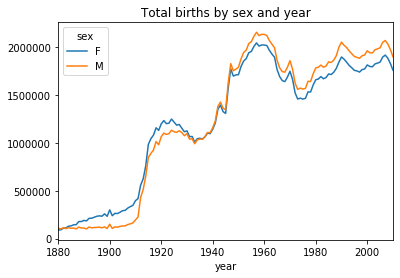

In [75]:
total_births.plot(title='Total births by sex and year')

下面我们来插入一个prop列，用于存放指定名字的婴儿数相对于总出生数的比例。prop值为0.2表示每100名婴儿中有2名去了当前这个名字。因此，我们先按year和sex分组，然后在将新列加到各个分组上：

In [76]:
def add_prop(group):
    # 整数除法会向下圆整？python3 不需要
    births = group.births.astype(float)
    
    group['prop'] = births / births.sum()
    return group

names = names.groupby(['year', 'sex']).apply(add_prop)

在执行这样的分组处理时，一般都应该做一些有效性检查，比如验证多有分组的prop的总和是否为1.由于这是一个浮点数型数据，所有我们应该用np.allclose来检查这个分组总计值是否足够近似于1：

In [77]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

这样就算完活了。为了便于实现更进一步的分析，我需要取出该数据的一个子集：每队sex/year组合的钱1000个名字

In [78]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

In [79]:
top1000.head()

name sex  births  year      prop
year sex                                         
1880 F   0       Mary   F    7065  1880  0.077643
         1       Anna   F    2604  1880  0.028618
         2       Emma   F    2003  1880  0.022013
         3  Elizabeth   F    1939  1880  0.021309
         4     Minnie   F    1746  1880  0.019188

## 分析命名趋势

有了完整的数据集和刚才生成的top1000数据集，我们就可以开始分析各种命名趋势了。首先将前1000个名字分为男女两部分：

In [80]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

这是两个简单的时间序列，只需要稍作整理即可绘制出相应的图表。我们先生成一张按year和name统计的总出生数透视表，这里需要对原书进行修改，英文索引有重复：

In [85]:
top1000_plot = top1000.droplevel('year')

In [87]:
total_births = top1000_plot.pivot_table('births', index='year', columns='name', aggfunc=sum)

现在，我们用DataFrame的plot方法绘制几个名字的曲线图：

In [88]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001BC1D1D7128>,
      dtype=object)

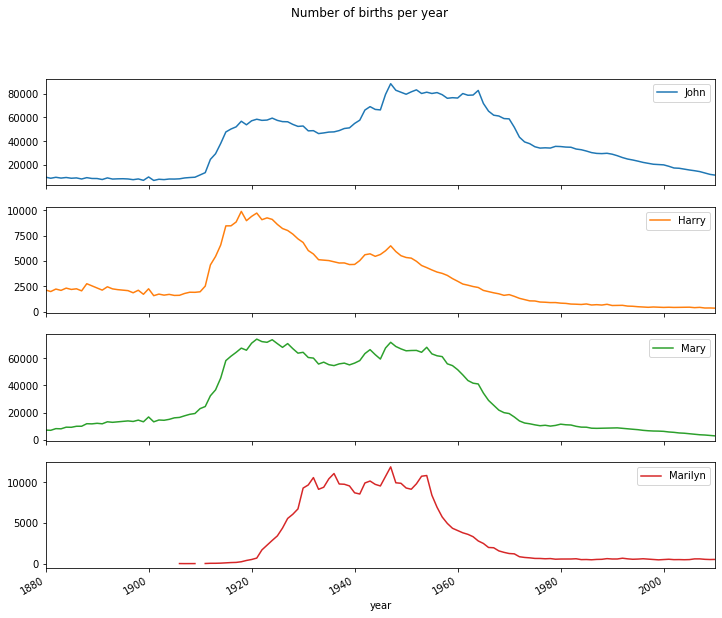

In [89]:
subset.plot(subplots=True, figsize=(12,10), grid=False, title="Number of births per year")

## 评估命名多样性的增长

上图所反映的降低情况可能意味着父母愿意给小孩起长线的名字越来越少。这个假设可以从数据中得到验证。一个办法是计算最流行的1000个名字所占的比例，我按year和sex进行聚合并绘图：

In [92]:
top1000_plot2 = top1000_plot.droplevel('sex')

In [93]:
table = top1000_plot2.pivot_table('prop', index='year', columns='sex', aggfunc=sum)

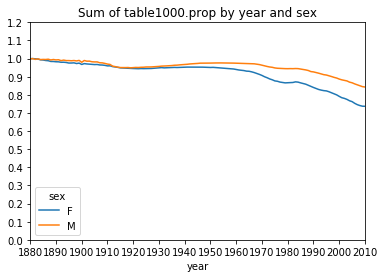

In [94]:
table.plot(title='Sum of table1000.prop by year and sex', yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

结果如图，从图中可以看出，名字的多样性确实出现了增长（前1000项的比例降低）。另一个办法是计算总出生人数前50%的不同名字的数量，这个数字不太好计算。我们只考虑2010年男孩的名字：

In [95]:
df = boys[boys.year == 2010]

In [96]:
df.head()

name sex  births  year      prop
year sex                                             
2010 M   1676644    Jacob   M   21875  2010  0.011523
         1676645    Ethan   M   17866  2010  0.009411
         1676646  Michael   M   17133  2010  0.009025
         1676647   Jayden   M   17030  2010  0.008971
         1676648  William   M   16870  2010  0.008887

在对prop降序排列之后，我们想知道前面多少个名字的人数加起来才够50%。虽然编写一个for循环确实也能达到目的，但NumPy有一种更聪明的矢量方式。先计算prop的累计和cumsum，然后再通过searchsorted方法找出0.5应该被插入在那个位置才能保证不破坏顺序：

In [98]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()

In [99]:
prop_cumsum[:10]

year  sex         
2010  M    1676644    0.011523
           1676645    0.020934
           1676646    0.029959
           1676647    0.038930
           1676648    0.047817
           1676649    0.056579
           1676650    0.065155
           1676651    0.073414
           1676652    0.081528
           1676653    0.089621
Name: prop, dtype: float64

由于数组索引是从0开始的，因此我们要给这个结果加1，即最终结果为117.拿1900年的数据来做个比较，这个数字要小得多：

In [100]:
df = boys[boys.year == 1990]

In [101]:
in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()

In [102]:
# 原书结果是25
in1900.searchsorted(0.5) + 1

45

现在就可以对所有year/sex组合执行这个计算了。按这两个字段进行groupby处理，然后用一个函数计算各分组的这个值：

In [103]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1

diversity = top1000_plot2.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

现在，diversity这个DataFrame拥有两个时间序列（每个性别各一个，按年度索引）。

In [104]:
diversity.head()

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


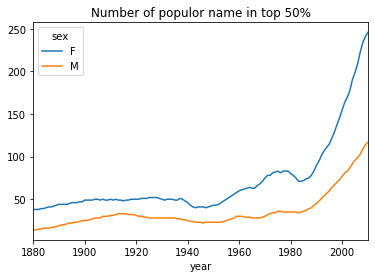

In [105]:
diversity.plot(title='Number of populor name in top 50%')

从图中可以看出，女孩名字的多样性总是比男孩的高，而且还在变得越来越高

## “最后一个字母”的变革

2007年，一名婴儿姓名研究人员Laura Wattenberg在她自己的网站指出：近百年来，男孩名字最后一个字母上的分布发生了显著的变化。为了了解具体的情况，我首先将全部出生数据在年度、性别以及末尾字幕进行聚合：

In [106]:
# 从name列取出最后一个字母
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table = names.pivot_table('births', index=last_letters, columns=['sex', 'year'], aggfunc=sum)

然后，我选出具有一定代表性的三年，并输出前面几行：

In [107]:
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')

In [108]:
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

接下来我们需要按总出生数对该表进行规范化处理，以便于计算出各性别各末尾字幕占总出生人数的比例：

In [109]:
subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

In [110]:
letter_prop = subtable / subtable.sum()

有了这个字幕比例数据之后，就可以生成一张各年度性别的条形图

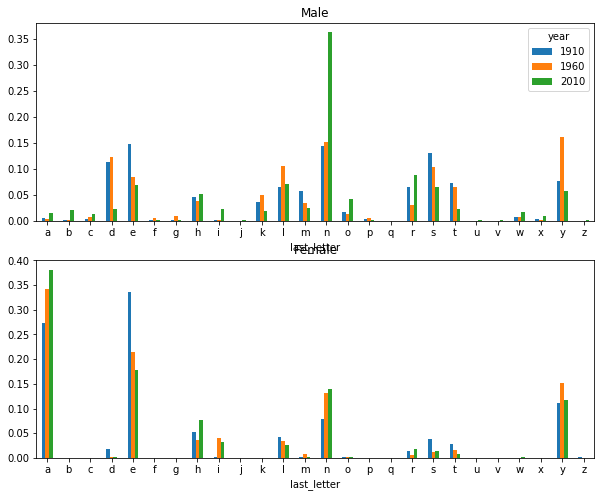

In [112]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female', legend=False)

从图中可以看出，从20世纪60年代开始，以字幕n结尾的男孩名字出现了显著的增长。回到之前创建的那个完整表，按年度和性别对其进行规范化处理，并在男孩名字中选取几个字幕，最后进行转置以便将各个列做成一个时间序列：

In [113]:
letter_prop = table / table.sum()

In [114]:
dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T

In [115]:
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


有了这个时间序列的DataFrame之后，就可以通过其plot方法绘制出一张趋势图

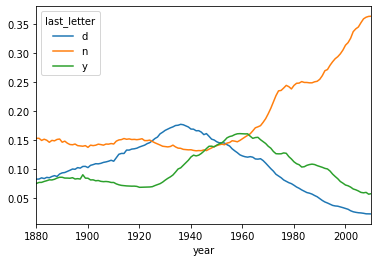

In [116]:
dny_ts.plot()

## 变成女孩名字和男孩名字（及相反情况）

另一个有趣的趋势是，早年流行于男孩的名字近年来变成女孩名字，例如Lesley或Leslie。回到top1000数据集，找出其中以lesl开头的一组名字：

In [117]:
all_names = top1000_plot2.name.unique()

In [118]:
mask = np.array(['lesl' in x.lower() for x in all_names])

In [119]:
lesley_like = all_names[mask]

In [120]:
lesley_like

array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

然后利用这个结果过滤其他的名字，并按名字分组计算出生数以查看相对频率：

In [121]:
filtered = top1000_plot2[top1000_plot2.name.isin(lesley_like)]

In [122]:
filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

接下来，我们按性别和年度进行聚合，并按年度进行规范化处理：

In [123]:
table = filtered.pivot_table('births', index='year', columns='sex', aggfunc='sum')

In [124]:
table = table.div(table.sum(1), axis=0)

In [125]:
table.tail()

sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


现在，我们可以轻松绘制一张分性别的年度曲线图了

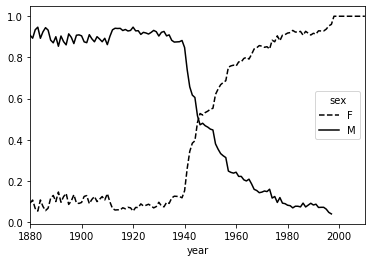

In [126]:
table.plot(style={'M':'k-', 'F':'k--'})

# 小结及展望

本章中的这些例子都非常简单，但它们可以让你大致了解后续章节的相关内容。本书关注的角点是工具而不是哪些精妙的分析方法。zip握本书所介绍的技术将使你能够立马展开自己的分析工作。